In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

import os
import pathlib
import time
import datetime
import numpy as np
import scipy
import scipy.io as sio
from scipy.stats import kurtosis
from scipy import signal
from sklearn.model_selection import train_test_split
from  sklearn.utils import shuffle
from os import path, mkdir
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import itertools
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors
import urllib.request
import sys
import glob
import os
import matplotlib as mpl
import pandas as pd
from matplotlib import pyplot as plt
from IPython import display
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Reshape, Dropout, LSTM, Bidirectional, BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D, MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.utils import np_utils
!pip install komm
import komm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, UpSampling1D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# input arguments

In [ ]:
# input variables
firstCondition = "1797"
secondCondition = "1730"
classifierType = "convlstm" # convAE or CNN
n_class = 6
output_dir = "./out"
length = 512
train_size = .8
input_dir = "./input"
y_target = 1
# for idx, arg in argv:


In [ ]:
from os import path, mkdir
def make_dir(dir):
  if not path.exists(dir):
      mkdir(dir)
      print(dir + ' is created!')
  else: print(dir + ' exists!')
  return 
make_dir(output_dir)

./out is created!


In [ ]:
def noise_maker(data, snr=0.1, signal_power=1.0):
    awgn = komm.AWGNChannel(snr=snr, signal_power=signal_power)
    return awgn(data)

def burst_maker(Input, stride=10, length=200, snr=100.):
    """
    :param Input: The raw signal of each sensor. (Numpy array: )
    :param stride: The interval between each sample (integer number) - by default = 10
    :param length: The length of the burst (integer number) - by default = 200
    :return: A numpy array with processed signal
    """
    if stride < length:
        r = int(np.floor((len(Input) - length + stride) / stride))  # r = number of bursts
    else:
        r = int(np.floor(len(Input) / stride))  # r = number of bursts

    Input = np.reshape(Input, (-1,))  # to make sure it's a vertical numpy vector
    Output = np.zeros((r, 1, length))  # makes a 3d matrix with all zero values

    for i in range(r):
        start = int(i * stride)  # starting timestamp
        burst = Input[start: start + length]  # the current burst on which we process
        if snr:  # None: without noise
          burst = noise_maker(burst, snr=snr, signal_power=1.0)

        Output[i, 0, :] = burst

    return Output

def splitter(X, y, test_size=0.2):
    m = len(y)
    if test_size <= 1:
        n = int(test_size * m)
    else:
        n = int(test_size)
    y_test = y[-n:]
    y_train = y[0:(m - n)]
    X_test = X[-n:, :, :]
    X_train = X[0:(m - n), :, :]
    return X_train, X_test, y_train, y_test

def print_percent_done(index, total, bar_len=50, title='Please wait'):
    '''
    index is expected to be 0 based index. 
    0 <= index < total
    '''
    percent_done = (index+1)/total*100
    percent_done = round(percent_done, 1)

    done = round(percent_done/(100/bar_len))
    togo = bar_len-done

    done_str = '█'*int(done)
    togo_str = '░'*int(togo)

    print(f'\t⏳{title}: [{done_str}{togo_str}] {percent_done}% done')

    if round(percent_done) == 100:
        print('\t✅')

def DataLoader(dir, length=200, stride=100, train_size=.8, val_size=.1, snr=None, save=False, load=False, file_name='Temporary.npz', file_dir=''):
    """
    :param dir: [The directory of the .mat file, name of DE header, name of FE header, label]
    :param length: Length of the burst: int
    :param stride: Timestamp between bursts: int
    :param train_size: proportion of the whole dataset to be used as training set
    :param val_size: proportion of non-training set to be used as evaluation set
    :param noise: Random noise severity (real number between 0.0 and 1.0)
    :param save: If it's True, it saves the file into an .NPZ file
    :param load: If it's True, it loads the file from an .NPZ file
    :param file_name: The name of an .NPZ file to be loaded or saved
    :param file_dir: The directory of the final .NPZ file to be loaded from / saved to
    :return: X_trian, X_test, X_val, y_train, y_test, y_val: numpy array
    """
    if load == True:
        A = np.load(file_dir + file_name)
        X_train, X_test, X_val, y_train, y_test, y_val = \
            A['name1'], A['name2'], A['name3'], A['name4'], A['name5'], A['name6']
        print('=== ' ,file_name, 'is loaded ===')
    else:
        j = 0
        
        for d, n1, n2, label in dir:
            A = sio.loadmat(d)
            class_i = np.concatenate([A[n1], A[n2]], axis=1)  # allocates the sensor data to each column
            print_percent_done(j, len(glob.glob(f'{file_dir}*.mat')), bar_len=50, title='Creating the dataset')

            h_train = class_i[:int(len(class_i) * train_size), :]  # returns the first 80% of class_i data timestamps
            h_test = class_i[int(len(class_i) * train_size):, :]  # returns the last 20% of class_i data timestamps

            X_tr = burst_maker(h_train[:, 0], stride=stride, length=length, snr=snr)  # the first sensor's processed data
            for i in np.arange(start=1, stop=len(h_train[0, :])):  # the remaining sensors
                a = burst_maker(h_train[:, i], stride=stride, length=length, snr=snr)
                X_tr = np.concatenate([X_tr, a], axis=1)
            y_tr = np.full((len(X_tr), 1), label['class'])  # labels class_i samples with 0

            X_te = burst_maker(h_test[:, 0], stride=stride, length=length, snr=snr)  # the first sensor's processed data
            for i in np.arange(start=1, stop=len(h_test[0, :])):  # the remaining sensors
                a = burst_maker(h_test[:, i], stride=stride, length=length, snr=snr)
                X_te = np.concatenate([X_te, a], axis=1)
            y_te = np.full((len(X_te), 1), label['class'])  # labels class_i samples with 0

            if j == 0:
                X_train = X_tr
                y_train = y_tr
                X_test = X_te
                y_test = y_te
            else:
                X_train = np.concatenate([X_train, X_tr])
                y_train = np.concatenate([y_train, y_tr])
                X_test = np.concatenate([X_test, X_te])
                y_test = np.concatenate([y_test, y_te])

            j += 1

            X_train, y_train = shuffle(X_train, y_train)  # only shuffles

            X_test, y_test = shuffle(X_test, y_test)  # only shuffles

            X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=val_size, shuffle=True)  # only shuffles

        if save == True:
            np.savez(file_dir + file_name, name1=X_train, name2=X_test, name3=X_val,
                     name4=y_train, name5=y_test, name6=y_val)
            print('=== ', file_name, 'is successfully saved ===!')

    return X_train, X_test, X_val, y_train, y_test, y_val

def concatInputGT(x_train_norm,x_train_inner):
  i = 0
  x_train = []
  for i in range(len(x_train_norm)):
    x_train.append(np.concatenate([x_train_norm[i],x_train_inner[i]]))

  x_train = np.array(x_train)
  return tf.convert_to_tensor(x_train, np.float32)

def splitSignal(x):
  splitted = tf.split(x, 2)
  return  splitted[0],splitted[1]

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv1D(filters, size, strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv1DTranspose(filters, size, strides=1,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[length,1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64) (batch_size, 8, 8, 4)
    downsample(128, 4),  # (batch_size, 64, 64, 128)  (batch_size, 4, 4, 8)
    downsample(256, 4),  # (batch_size, 32, 32, 256) (batch_size, 2, 2, 16)
    downsample(length, 4),  # (batch_size, 16, 16, 512)(batch_size, 1, 1, 16)
    downsample(length, 4),  # (batch_size, 16, 16, 512)(batch_size, 1, 1, 16)
  ]

  up_stack = [
    #upsample(length, 4),  # (batch_size, 16, 16, 1024)
    upsample(length, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv1DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=1,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[length,1], name='input_image')
  tar = tf.keras.layers.Input(shape=[length,1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding1D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv1D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding1D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv1D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(10, 5), dpi=150)
  

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Normal', 'Ground Truth', 'Generated Fault']

  clrs = ['#BFC0C0' ,'#4F5D75', '#FFAC11']

  for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.title(title[i], fontsize=9)
    if i<2: plt.xticks([])
    if i == 1: plt.ylabel('Amplitude', fontsize=9)
    # Getting the pixel values in the [0, 1] range to plot.
    # plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.plot(display_list[i], c = clrs[i])
    # plt.axis('off')
  plt.show()
  
  plt.savefig(output_dir+f'/img/DataSamples{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.png')
  # savez_compressed("xFake_"+str(firstCondition)+".npz", xFake)

@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

# Functions 
includeFrequencyFeatures = True

def getFeatures(data, includeFrequencyFeatures=includeFrequencyFeatures):
    data = data.squeeze()

    #---- Time-Domain Features ----
    # mean
    mean = np.mean(data, axis=1)
    
    # standard deviation
    std = np.std(data, axis=1)

    #Skewness
    skewness = scipy.stats.skew(data, axis=1)

    # # RMS
    rms = np.sqrt(np.mean(np.square(data), axis=1))

    # shape factor
    shape_factor = np.sqrt(np.sum(np.square(data), axis=1)) / np.sum(np.abs(data), axis=1)

    # kurtosis
    kurtosis = scipy.stats.kurtosis(data, axis=1, fisher=True, bias=True, nan_policy='propagate')

    # peaking factor
    peaking_factor = np.max(data, axis=1) / np.sum(np.abs(data), axis=1)

    # peak to peak
    peak_to_peak = np.max(data, axis=1) - np.min(data, axis=1)

    # pulse factor
    pulse_factor = np.sum(np.abs(np.diff(data, axis=1)), axis=1) / np.sum(np.abs(data), axis=1)

    # crest factor
    crest_factor = np.max(data, axis=1) / np.abs(np.min(data, axis=1))

    # # variance
    # variance = np.var(data, axis=1)

    # # peak to peak
    # peak_to_peak = np.max(data, axis=1) - np.min(data, axis=1)

    # # peaking factor
    # peaking_factor = np.max(data, axis=1) / np.sum(np.abs(data), axis=1)

    # # pulse factor
    # pulse_factor = np.sum(np.abs(np.diff(data, axis=1)), axis=1) / np.sum(np.abs(data), axis=1)

    # # margin factor
    # margin_factor = np.sum(np.abs(np.diff(data, axis=1)), axis=1) / np.sum(np.abs(data), axis=1)

    if includeFrequencyFeatures:
        #---- Frequency-Domain Features ----
        frequency_data = np.fft.fft(data, axis=1)
        frequency_data_mag = np.abs(frequency_data)
        frequency_data_phase = np.angle(frequency_data)

        # spectral centroid
        #spectral_centroid = np.mean(frequency_data, axis=1)
        spectral_centroid_mag = np.mean(frequency_data_mag, axis=1)
        spectral_centroid_phase = np.mean(frequency_data_phase, axis=1)

        # spectral spread
        #spectral_spread = np.std(frequency_data, axis=1)
        spectral_spread_mag = np.std(frequency_data_mag, axis=1)
        spectral_spread_phase = np.std(frequency_data_phase, axis=1)

        # Root Mean Square of the frequency spectrum
        #rms_frequency = np.sqrt(np.mean(np.square(frequency_data_mag), axis=1))

        # spectral skewness
        #spectral_skewness = scipy.stats.skew(frequency_data, axis=1)
        spectral_skewness_mag = scipy.stats.skew(frequency_data_mag, axis=1)
        spectral_skewness_phase = scipy.stats.skew(frequency_data_phase, axis=1)

        # spectral crest factor
        #spectral_crest_factor = np.max(frequency_data, axis=1) / np.abs(np.min(frequency_data, axis=1))
        spectral_crest_factor_mag = np.max(frequency_data_mag, axis=1) / np.abs(np.min(frequency_data_mag, axis=1))
        spectral_crest_factor_phase = np.max(frequency_data_phase, axis=1) / np.abs(np.min(frequency_data_phase, axis=1))

        # shannon entropy
        shannon_entropy = -np.sum(frequency_data * np.log(frequency_data), axis=1)
        shannon_entropy_mag = -np.sum(frequency_data_mag * np.log(frequency_data_mag), axis=1)
        shannon_entropy_phase = -np.sum(frequency_data_phase * np.log(frequency_data_phase), axis=1)

        features = np.stack((mean, std, skewness, rms, kurtosis, crest_factor, spectral_centroid_mag, spectral_spread_mag, spectral_skewness_mag, spectral_crest_factor_mag, shannon_entropy_mag)).T
    
    else:
        features = np.stack((mean, skewness, std, kurtosis, crest_factor)).T

    return features

if includeFrequencyFeatures:
    # feature_names = ['mean', 'std', 'rms', 'shape_factor', 'kurtosis', 'peaking_factor', 'peak_to_peak', 'pulse_factor', 'spectral_centroid_mag', 'spectral_spread_mag', 'shannon_entropy_mag']
    #feature_names = ['mean', 'std', 'skewness', 'rms', 'shape_factor', 'kurtosis', 'peaking_factor', 'peak_to_peak', 'pulse_factor', 'crest_factor', 'spectral_centroid_mag', 'spectral_spread_mag', 'spectral_skewness_mag', 'spectral_crest_factor_mag', 'shannon_entropy_mag']
    feature_names = ['mean', 'std', 'skewness', 'kurtosis', 'crest_factor', 'spectral_centroid_mag', 'spectral_spread_mag', 'spectral_skewness_mag', 'spectral_crest_factor_mag', 'shannon_entropy_mag']
else:
    feature_names = ["mean", "skewness", "std", "kurtosis", "crest_factor"]

def plot_clusters(components, labels, labelNames=None, plotClasses=None, condition=None, title=None, colors=None, alpha=0.05):
    if plotClasses == None:
        plotClasses = np.unique(labels).astype(int)
    if labelNames == None:
        labelNames = plotClasses 
    try:
        condition = f'Condition-{condition}'
    except:
        condition = "Condition-Unknown"

    plt.figure(figsize=(8, 6), dpi=150)
    plt.title(title)
    for j in plotClasses:
        plt.scatter(components[labels == j,0], components[labels == j,1], c=colors[j], alpha=alpha, label=labelNames[j])
    plt.legend()
    plt.xlabel(f'Component1')
    plt.ylabel(f'Component2')
    plt.savefig(f'{condition}_{title}.png')
    plt.show()
    plt.savefig('t-SNE.png')

In [ ]:
# 1st Condition = 1797
# Choose the second condition


# if firstCondition == "1797":
#   if secondCondition == "1730":
#       data_codes = {'97': {'class':0, 'rpm':1797}, '100':{'class':0, 'rpm':1730},
#   '105':{'class':1, 'rpm':1797},'108':{'class':1, 'rpm':1730}} # keys: data codes in CWRU website  [IT'S ONLY SOME OF THE WHOLE DATA]

#   elif secondCondition == "1750":
#       data_codes = {'97': {'class':0, 'rpm':1797}, '99':{'class':0, 'rpm':1750},
#   '105':{'class':1, 'rpm':1797},'107':{'class':1, 'rpm':1750}} # keys: data codes in CWRU website  [IT'S ONLY SOME OF THE WHOLE DATA]

#   elif secondCondition == "1772":
#        data_codes = {'97': {'class':0, 'rpm':1797}, '98':{'class':0, 'rpm':1772},
#   '105':{'class':1, 'rpm':1797},'106':{'class':1, 'rpm':1772}} # keys: data codes in CWRU website  [IT'S ONLY SOME OF THE WHOLE DATA]

# elif firstCondition == "1772":
#     if secondCondition == "1730":
#       data_codes = {'98': {'class':0, 'rpm':1772}, '100':{'class':0, 'rpm':1730},
#   '106':{'class':1, 'rpm':1772},'108':{'class':1, 'rpm':1730}} # keys: data codes in CWRU website  [IT'S ONLY SOME OF THE WHOLE DATA]
#     elif secondCondition == "1750":
#       data_codes = {'98': {'class':0, 'rpm':1772}, '99':{'class':0, 'rpm':1750},
#   '106':{'class':1, 'rpm':1772},'107':{'class':1, 'rpm':1750}} # keys: data codes in CWRU website  [IT'S ONLY SOME OF THE WHOLE DATA]
#     elif secondCondition == "1797":
#        data_codes = {'97': {'class':0, 'rpm':1797}, '98':{'class':0, 'rpm':1772},
#   '105':{'class':1, 'rpm':1797},'106':{'class':1, 'rpm':1772}} # keys: data codes in CWRU website  [IT'S ONLY SOME OF THE WHOLE DATA]


if (firstCondition == "1797" and  secondCondition == "1730") or (firstCondition == "1730" and  secondCondition == "1797"):
    data_codes = {'97': {'class':0, 'rpm':1797}, '100':{'class':0, 'rpm':1730},
'105':{'class':1, 'rpm':1797},'108':{'class':1, 'rpm':1730}} 

elif (firstCondition == "1797" and  secondCondition == "1750") or (firstCondition == "1750" and  secondCondition == "1797"):
    data_codes = {'97': {'class':0, 'rpm':1797}, '99':{'class':0, 'rpm':1750},
'105':{'class':1, 'rpm':1797},'107':{'class':1, 'rpm':1750}} 

elif (firstCondition == "1797" and  secondCondition == "1772") or (firstCondition == "1772" and  secondCondition == "1797"):
      data_codes = {'97': {'class':0, 'rpm':1797}, '98':{'class':0, 'rpm':1772},
'105':{'class':1, 'rpm':1797},'106':{'class':1, 'rpm':1772}} 

elif (firstCondition == "1772" and  secondCondition == "1750") or (firstCondition == "1750" and  secondCondition == "1772"):
      data_codes = {'99':{'class':0, 'rpm':1750}, '98':{'class':0, 'rpm':1772},
'107':{'class':1, 'rpm':1750},'106':{'class':1, 'rpm':1772}}

elif (firstCondition == "1772" and  secondCondition == "1730") or (firstCondition == "1730" and  secondCondition == "1772"):
      data_codes = {'100':{'class':0, 'rpm':1730}, '98':{'class':0, 'rpm':1772},
'108':{'class':1, 'rpm':1730},'106':{'class':1, 'rpm':1772}}

elif (firstCondition == "1750" and  secondCondition == "1730") or (firstCondition == "1730" and  secondCondition == "1750"):
      data_codes = {'100':{'class':0, 'rpm':1730}, '99':{'class':0, 'rpm':1750},
'108':{'class':1, 'rpm':1730},'107':{'class':1, 'rpm':1750}}



dir = []

for k,v in data_codes.items():
  print('k =', k, ' | ', v)
  if path.isfile(data_dir + k + '.mat'): pass  # if it is already downloaded
  else:
    urllib.request.urlretrieve(f"http://engineering.case.edu/sites/default/files/{k}.mat",
                               data_dir + k + '.mat')
  
  data = scipy.io.loadmat(data_dir + k + '.mat')
  if len(k) == 2: k_3 = '0'+k
  elif len(k) == 3: k_3 = k
  de = f'X{k_3}_DE_time'
  fe = f'X{k_3}_FE_time'
  
  dir.append([data_dir + k + '.mat' ,de, fe, v])
print('=== download complete! ===')

length = 512
stride = 50


if firstCondition == "1797":
    x1_normal0 = sio.loadmat('./data/97.mat')['X097_DE_time']
    x1_inner0 = sio.loadmat('./data/105.mat')['X105_DE_time']
elif firstCondition == "1772":
      x1_normal0 = sio.loadmat('./data/98.mat')['X098_DE_time']
      x1_inner0 = sio.loadmat('./data/106.mat')['X106_DE_time']
elif firstCondition == "1750":
        x1_normal0 = sio.loadmat('./data/99.mat')['X099_DE_time']
        x1_inner0 = sio.loadmat('./data/107.mat')['X107_DE_time']
elif firstCondition == "1730":
        x1_normal0 = sio.loadmat('./data/100.mat')['X100_DE_time'] 
        x1_inner0 = sio.loadmat('./data/108.mat')['X108_DE_time'] 

if secondCondition == "1797":
    x1_normal02 = sio.loadmat('./data/97.mat')['X097_DE_time']
    x1_inner02 = sio.loadmat('./data/105.mat')['X105_DE_time']
elif secondCondition == "1772":
      x1_normal02 = sio.loadmat('./data/98.mat')['X098_DE_time']
      x1_inner02 = sio.loadmat('./data/106.mat')['X106_DE_time']
elif secondCondition == "1750":
        x1_normal02 = sio.loadmat('./data/99.mat')['X099_DE_time']
        x1_inner02 = sio.loadmat('./data/107.mat')['X107_DE_time']
elif secondCondition == "1730":
        x1_normal02 = sio.loadmat('./data/100.mat')['X100_DE_time'] 
        x1_inner02 = sio.loadmat('./data/108.mat')['X108_DE_time'] 


len0 = len(x1_inner0)

x_normal = burst_maker(x1_normal0,length=length, stride=stride).transpose(0,2,1)
x_inner = burst_maker(x1_inner0,length=length, stride=stride).transpose(0,2,1)

x_normal2 = burst_maker(x1_normal02,length=length, stride=stride).transpose(0,2,1)
x_inner2 = burst_maker(x1_inner02,length=length, stride=stride).transpose(0,2,1)

an = min(len(x_normal),len(x_inner))
y_normal = np.zeros(an)
y_inner = np.ones(an)

train_rate = 0.75
# n = 473
n = an

random.shuffle(x_normal)
random.shuffle(x_inner)

num_train = int(np.round(n*train_rate))

x_train_norm = x_normal[0:num_train]
x_test_norm = x_normal[num_train+1:n]


x_train_inner = x_inner[0:num_train]
x_test_inner = x_inner[num_train+1:n+1]

# RPM2
random.shuffle(x_normal2)
random.shuffle(x_inner2)


x_train_norm2 = x_normal2[0:num_train]
x_test_norm2 = x_normal2[num_train+1:n+1]


x_train_inner2 = x_inner2[0:num_train]
x_test_inner2 = x_inner2[num_train+1:n+1]


BUFFER_SIZE = 200
train_dataset = tf.data.Dataset.from_tensor_slices(concatInputGT(x_train_norm,x_train_inner))

train_dataset = train_dataset.map(splitSignal,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(concatInputGT(x_test_norm,x_test_inner))

test_dataset = test_dataset.map(splitSignal,
                                  num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(1)

test_dataset2 = tf.data.Dataset.from_tensor_slices(concatInputGT(x_test_norm2,x_test_inner2))

test_dataset2 = test_dataset2.map(splitSignal,
                                  num_parallel_calls=tf.data.AUTOTUNE)
test_dataset2 = test_dataset2.shuffle(355)
test_dataset2 = test_dataset2.batch(1)

OUTPUT_CHANNELS = 1 #3

# Generator

generator = Generator()

LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator

discriminator = Discriminator()

# define the optimizer and a checkpoint saver

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# if firstCondition == "1797":
#   checkpoint_dir = f'./drive/MyDrive/training_checkpoints/{firstCondition}'
# elif firstCondition == "1772":
#   checkpoint_dir = './drive/MyDrive/training_checkpoints72'
# elif firstCondition == "1750":
#     checkpoint_dir = './drive/MyDrive/training_checkpoints50'
# elif firstCondition == "1730":
#     checkpoint_dir = './drive/MyDrive/training_checkpoints30'

checkpoint_dir = f'./drive/MyDrive/training_checkpoints/{firstCondition}'
make_dir(checkpoint_dir)

# checkpoint_dir = './drive/MyDrive/training_checkpoints'
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt-"+str(firstCondition)+"-to-"+str(secondCondition))
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


preTrained = False
for file in os.listdir(checkpoint_dir):
    # if file.startswith("ckpt-"+str(firstCondition)+"-to-"+str(secondCondition)):
      preTrained = True
      checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
if not preTrained:
  fit(train_dataset, test_dataset, steps=40000)

# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# # if checkpoint
  

# Run the trained model on a few examples from the test set in second condition
for example_input, example_target in test_dataset2.take(5):
  generate_images(generator, example_input, example_target)

# Run the trained model on a few examples from the test set in first condition
# for inp, tar in test_dataset.take(5):
#   generate_images(generator, inp, tar)

numSample = len(test_dataset)

xFake = []
for inp, tar in test_dataset.take(numSample):
  prediction = generator(inp, training=True)
  xFake.append(prediction[0])

xFake2 = []
for inp, tar in test_dataset2.take(numSample):
  prediction2 = generator(inp, training=True)
  xFake2.append(prediction2[0])

# save data
# savez_compressed("xFake_"+str(firstCondition)+".npz", xFake)

y = np.zeros((xFake.shape[0],1))+1
channel_names = ['Raw']
class_names = ['Heathy', 'Inner', 'Ball', 'Outer@6', 'Outer@3', 'Outer@12']
np.savez("xFake_"+str(firstCondition)+".npz", X=xFake, y=y, channel_names=channel_names, class_names=class_names)
np.savez("xFake_"+str(secondCondition)+".npz", X=xFake2, y=y, channel_names=channel_names, class_names=class_names)


k = 97  |  {'class': 0, 'rpm': 1797}
k = 100  |  {'class': 0, 'rpm': 1730}
k = 105  |  {'class': 1, 'rpm': 1797}
k = 108  |  {'class': 1, 'rpm': 1730}
=== download complete! ===


FileNotFoundError: ignored

In [ ]:
y = np.zeros((xFake.shape[0],1))+1
channel_names = ['Raw']
class_names = ['Heathy', 'Inner', 'Ball', 'Outer@6', 'Outer@3', 'Outer@12']
np.savez("xFake_"+str(firstCondition)+".npz", X=xFake, y=y, channel_names=channel_names, class_names=class_names)
np.savez("xFake_"+str(secondCondition)+".npz", X=xFake2, y=y, channel_names=channel_names, class_names=class_names)

In [ ]:
# checkpoint_dir = './drive/MyDrive/training_checkpoints/'

# print(str(checkpoint_dir)+"ckpt_"+str(firstCondition)+"_to_"+str(secondCondition)+"-56.000.data")


In [ ]:
# !touch ./drive/MyDrive/training_checkpoints/ckpt_1797_to_1730-56.000.data

In [ ]:
data_codes = {'97': {'class':0, 'rpm':1797},'98':{'class':0, 'rpm':1772}, '99':{'class':0, 'rpm':1750}, '100': {'class':0, 'rpm':1730},
              '105':{'class':1, 'rpm':1797}, '106':{'class':1, 'rpm':1772}, '107':{'class':1, 'rpm':1750}, '108':{'class':1, 'rpm':1730},
              '209':{'class':1, 'rpm':1797}, '210':{'class':1, 'rpm':1772}, '211':{'class':1, 'rpm':1750}, '212':{'class':1, 'rpm':1730},
              '118':{'class':2, 'rpm':1797}, '120':{'class':2, 'rpm':1750}, '121':{'class':2, 'rpm':1730},
              '130':{'class':3, 'rpm':1797}, '131':{'class':3, 'rpm':1772}, '132':{'class':3, 'rpm':1750},
              '156':{'class':5, 'rpm':1797}, '158':{'class':5, 'rpm':1772}, '159':{'class':5, 'rpm':1750}, '160':{'class':5, 'rpm':1730},
              '198':{'class':3, 'rpm':1772}, '199':{'class':3, 'rpm':1750}, 
              '144':{'class':4, 'rpm':1797}, '145':{'class':4, 'rpm':1772}, '146':{'class':4, 'rpm':1750},} # keys: data codes in CWRU website  [IT'S ONLY SOME OF THE WHOLE DATA]

data_codes_reversed = {}
for k,v in data_codes.items():
  data_codes_reversed[v['rpm']] = {}
  for i in range(n_class):
    data_codes_reversed[v['rpm']]['class'] = {i: k}
# # data_codes = {'97': {'class':0, 'rpm':1797},
# # '105':{'class':1, 'rpm':1797},} # keys: data codes in CWRU website  [IT'S ONLY SOME OF THE WHOLE DATA]


dir = []

for k,v in data_codes.items():
  print('k =', k, ' | ', v)
  if path.isfile(data_dir + k + '.mat'): pass  # if it is already downloaded
  else:
    urllib.request.urlretrieve(f"http://engineering.case.edu/sites/default/files/{k}.mat",
                               data_dir + k + '.mat')
  
  data = scipy.io.loadmat(data_dir + k + '.mat')
  if len(k) == 2: k_3 = '0'+k
  elif len(k) == 3: k_3 = k
  de = f'X{k_3}_DE_time'
  fe = f'X{k_3}_FE_time'
  
  dir.append([data_dir + k + '.mat' ,de, fe, v])
print('=== download complete! ===')


stride = 250  # stride
# length = int(4096/16)
#length = int(4096/8)
snr = 50  # signal to noise ratio (None or float)
train_size = 0.8  # ratio of training set to whole (between 0 and 1)
val_size = 0.05  # ratio of training set to whole (between 0 and 1)
file_dir='./data/'
if snr:
  file_name = f'S{stride}L{length}snr{int(snr)}.npz'
else:
  file_name = f'S{stride}L{length}.npz'

X_train, X_test, X_val, y_train, y_test, y_val = DataLoader(dir, length=length, stride=stride,
                                                            train_size=train_size, val_size=val_size, snr=snr,
                                                            save=True, load=False, file_name=file_name, file_dir=file_dir)

X_train = X_train[:,0,:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

X_test = X_test[:,0,:]
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_val = X_val[:,0,:]
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

input_shape = (X_train.shape[1],X_train.shape[2])
left_input = Input(input_shape)

# Create model

# convLSTM
model_convlstm = Sequential()

model_convlstm.add(Conv1D(filters=16, kernel_size=64, strides=16, padding='same',input_shape=input_shape))
model_convlstm.add(BatchNormalization())
model_convlstm.add(Activation("relu"))
model_convlstm.add(MaxPooling1D(strides=2))

model_convlstm.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same'))
model_convlstm.add(BatchNormalization())
model_convlstm.add(Activation("relu"))
model_convlstm.add(MaxPooling1D(strides=2))

model_convlstm.add(LSTM(units=64,))

model_convlstm.add(Dense(100,activation='sigmoid'))

model_convlstm.add(Dropout(0.5))
model_convlstm.add(Dense(n_class, activation = 'softmax'))
print(model_convlstm.summary())


print(model_convlstm.count_params())

# initialize optimizer and random generator within one fold
keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=156324)
# keras.optimizers.SGD(lr=0.01)
model_convlstm.compile(optimizer='adam',
                      loss='categorical_crossentropy', metrics=['accuracy'])

# CNN

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=16, kernel_size=64, strides=16, padding='same',input_shape=input_shape))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPooling1D(strides=2))

model_cnn.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPooling1D(strides=2))

model_cnn.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPooling1D(strides=2))

model_cnn.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPooling1D(strides=2))

model_cnn.add(Flatten())
model_cnn.add(Dense(100,activation='sigmoid'))

model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(n_class, activation = 'softmax'))

print(model_cnn.summary())
print(model_cnn.count_params())

keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=156324)
# keras.optimizers.SGD(lr=0.01)
model_cnn.compile(optimizer='adam',
                      loss='categorical_crossentropy', metrics=['accuracy'])

#ConvAE

model_convAE = Sequential()
# Encoder architecture
model_convAE.add(Conv1D(filters=32, kernel_size=64, strides=16, padding='same',input_shape=input_shape))
model_convAE.add(Activation("relu"))
model_convAE.add(MaxPooling1D(strides=2))

model_convAE.add(Conv1D(filters=16, kernel_size=3, strides=1, padding='same'))
model_convAE.add(Activation("relu"))
model_convAE.add(MaxPooling1D(strides=2))

model_convAE.add(Conv1D(filters=8, kernel_size=3, strides=1, padding='same'))
model_convAE.add(Activation("relu"))
model_convAE.add(MaxPooling1D(strides=2))

# Decoder architecture
model_convAE.add(Conv1D(filters=8, kernel_size=3, strides=1, padding='same'))
model_convAE.add(Activation("relu"))
model_convAE.add(UpSampling1D(2))
model_convAE.add(Conv1D(filters=16, kernel_size=3, strides=1, padding='same'))
model_convAE.add(Activation("relu"))
model_convAE.add(UpSampling1D(2))
model_convAE.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same'))
model_convAE.add(Activation("sigmoid"))

# Classifier
model_convAE.add(Flatten())
model_convAE.add(Dense(100,activation='sigmoid'))
# model_convAE.add(Dropout(0.5))
model_convAE.add(Dense(n_class, activation = 'softmax'))

print(model_convAE.summary())
print(model_convAE.count_params())

keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=156324)
# keras.optimizers.SGD(lr=0.01)
model_convAE.compile(optimizer='adam',
                      loss='categorical_crossentropy', metrics=['accuracy'])

#
save_model_path='./drive/MyDrive/training_checkpoints/Model'
earlystop = EarlyStopping(monitor= 'val_loss', min_delta=0 , patience=30, verbose=0, mode='auto')

numCSamp = 480
X_m = x_normal[0:numCSamp,:,:]
for c in range(n_class):
  if c == 0:  # because we've already added health
    continue
  elif c == y_target:
    X_m = np.concatenate((X_m, xFake2[0:numCSamp]))
  else:
    dcode = data_codes_reversed[secondCondition][c]
    a = sio.loadmat(f'./data/{dcode}.mat')[f'X{dcode}_DE_time']
    b = burst_maker(a, length=length, stride=stride).transpose(0,2,1)[0:numCSamp,:,:]
    X_m = np.concatenate((X_m, b))

true_labels_M1 =  np.concatenate((np.zeros(numCSamp), np.ones(numCSamp),2*np.ones(numCSamp),3*np.ones(numCSamp),4*np.ones(numCSamp),5*np.ones(numCSamp)))
true_labels_M1_One =  np.ones(numCSamp)
 


k = 97  |  {'class': 0, 'rpm': 1797}
k = 98  |  {'class': 0, 'rpm': 1772}
k = 99  |  {'class': 0, 'rpm': 1750}
k = 100  |  {'class': 0, 'rpm': 1730}
k = 105  |  {'class': 1, 'rpm': 1797}
k = 106  |  {'class': 1, 'rpm': 1772}
k = 107  |  {'class': 1, 'rpm': 1750}
k = 108  |  {'class': 1, 'rpm': 1730}
k = 209  |  {'class': 1, 'rpm': 1797}
k = 210  |  {'class': 1, 'rpm': 1772}
k = 211  |  {'class': 1, 'rpm': 1750}
k = 212  |  {'class': 1, 'rpm': 1730}
k = 118  |  {'class': 2, 'rpm': 1797}
k = 120  |  {'class': 2, 'rpm': 1750}
k = 121  |  {'class': 2, 'rpm': 1730}
k = 130  |  {'class': 3, 'rpm': 1797}
k = 131  |  {'class': 3, 'rpm': 1772}
k = 132  |  {'class': 3, 'rpm': 1750}
k = 156  |  {'class': 5, 'rpm': 1797}
k = 158  |  {'class': 5, 'rpm': 1772}
k = 159  |  {'class': 5, 'rpm': 1750}
k = 160  |  {'class': 5, 'rpm': 1730}
k = 198  |  {'class': 3, 'rpm': 1772}
k = 199  |  {'class': 3, 'rpm': 1750}
k = 144  |  {'class': 4, 'rpm': 1797}
k = 145  |  {'class': 4, 'rpm': 1772}
k = 146  |  {'c

NameError: ignored

Epoch 1/25
450/450 [==============================] - 9s 15ms/step - loss: 0.5333 - accuracy: 0.8217 - val_loss: 0.1492 - val_accuracy: 0.9767
Epoch 2/25
450/450 [==============================] - 5s 12ms/step - loss: 0.1534 - accuracy: 0.9563 - val_loss: 0.0370 - val_accuracy: 0.9884
Epoch 3/25
450/450 [==============================] - 5s 12ms/step - loss: 0.0790 - accuracy: 0.9791 - val_loss: 0.0140 - val_accuracy: 1.0000
Epoch 4/25
450/450 [==============================] - 7s 15ms/step - loss: 0.0612 - accuracy: 0.9827 - val_loss: 0.0118 - val_accuracy: 1.0000
Epoch 5/25
450/450 [==============================] - 6s 14ms/step - loss: 0.0603 - accuracy: 0.9832 - val_loss: 0.0294 - val_accuracy: 0.9884
Epoch 6/25
450/450 [==============================] - 5s 12ms/step - loss: 0.0434 - accuracy: 0.9869 - val_loss: 0.0178 - val_accuracy: 0.9884
Epoch 7/25
450/450 [==============================] - 6s 12ms/step - loss: 0.0316 - accuracy: 0.9919 - val_loss: 0.0089 - val_accuracy: 1.0000

<Figure size 432x288 with 0 Axes>

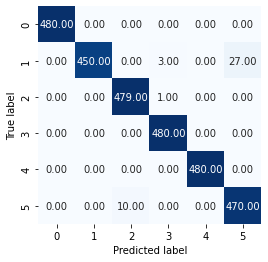

accuracy score = 98.57638888888889 %


In [ ]:
X_M1 = np.concatenate((xTest_B1,xFake2[0:numCSamp],D2,D3,D4,D5))
X_M1_One = xFake2[0:numCSamp]

if classifierType == "convlstm":
  model_convlstm.fit(X_train, np_utils.to_categorical(y_train, n_class),
                   validation_data = (X_val,np_utils.to_categorical(y_val, n_class)), epochs=25, batch_size=32, verbose=1, 
                   callbacks =[earlystop], shuffle = True)
  # model_convlstm.save('model_convlstm.h5')
  yPred_M1 = model_convlstm.predict(X_M1)

elif classifierType == "CNN":
  earlystop = EarlyStopping(monitor= 'val_loss', min_delta=0 , patience=30, verbose=0, mode='auto')
  history_cnn = model_cnn.fit(X_train, np_utils.to_categorical(y_train, n_class),
                              validation_data = (X_val,np_utils.to_categorical(y_val, n_class)),
                              epochs=25, batch_size=32, verbose=1, callbacks =[earlystop], shuffle = True)
  yPred_M1 = model_cnn.predict(X_M1)

elif classifierType == "convAE":
  earlystop = EarlyStopping(monitor= 'val_loss', min_delta=0 , patience=30, verbose=0, mode='auto')
  history_convAE = model_convAE.fit(X_train, np_utils.to_categorical(y_train, n_class),
                            validation_data = (X_val,np_utils.to_categorical(y_val, n_class)),
                            epochs=25, batch_size=32, verbose=1, callbacks =[earlystop], shuffle = True)
  yPred_M1 = model_convAE.predict(X_M1)




classes_M1 = np.argmax(yPred_M1, axis=1)
maximums_M1 = []

for arr in yPred_M1:
  maximums_M1.append(min(arr))
maximums_M1 = np.array(maximums_M1)


# conf

# matrix6 = confusion_matrix(true_labels_M1, classes_M1, normalize='true')
matrix = confusion_matrix(true_labels_M1, classes_M1)

matrix6 = pd.DataFrame(matrix)
plt.figure()
plt.figure(figsize=(4,4))
sns.heatmap(matrix, annot= True, fmt = ".2f",
           cmap = "Blues", cbar = False)
plt.yticks(rotation = 90)

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.savefig('confusion_matrix.png')

plt.show()
print(f'accuracy score = {accuracy_score(true_labels_M1, classes_M1) * 100} %')


# T-SNE



120

<Figure size 432x288 with 0 Axes>

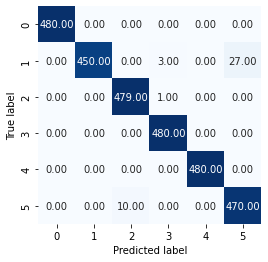

accuracy score = 98.57638888888889 %


In [ ]:
matrix = confusion_matrix(true_labels_M1, classes_M1)

matrix6 = pd.DataFrame(matrix)
plt.figure()
plt.figure(figsize=(4,4))
sns.heatmap(matrix, annot= True, fmt = ".2f",
           cmap = "Blues", cbar = False)
plt.yticks(rotation = 90)

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.savefig('confusion_matrix.png')

plt.show()
print(f'accuracy score = {accuracy_score(true_labels_M1, classes_M1) * 100} %')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:428: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:428: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:428: RuntimeWarning: invalid value encountered in multiply


(20643, 11)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(20643, 2)


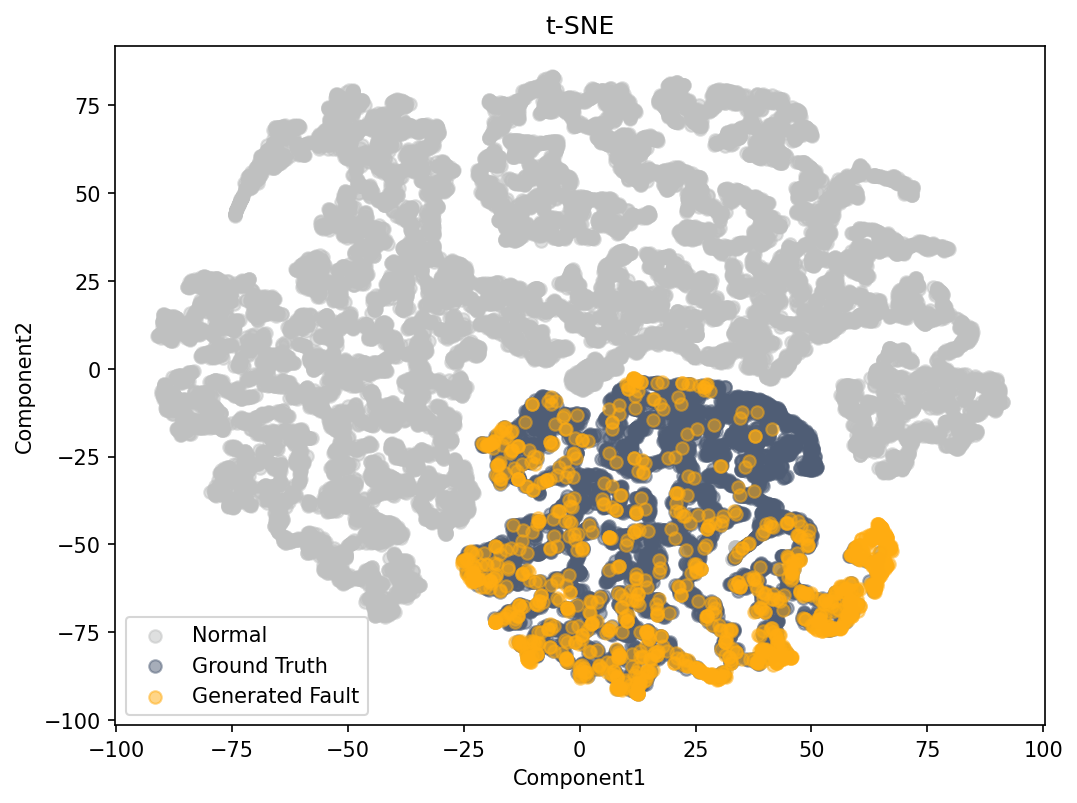

<Figure size 432x288 with 0 Axes>

In [ ]:
if (firstCondition == "1797" and  secondCondition == "1730") or (firstCondition == "1730" and  secondCondition == "1797"):
    data_codes = {'97': {'class':0, 'rpm':1797}, '100':{'class':0, 'rpm':1730},
'105':{'class':1, 'rpm':1797},'108':{'class':1, 'rpm':1730}} 

elif (firstCondition == "1797" and  secondCondition == "1750") or (firstCondition == "1750" and  secondCondition == "1797"):
    data_codes = {'97': {'class':0, 'rpm':1797}, '99':{'class':0, 'rpm':1750},
'105':{'class':1, 'rpm':1797},'107':{'class':1, 'rpm':1750}} 

elif (firstCondition == "1797" and  secondCondition == "1772") or (firstCondition == "1772" and  secondCondition == "1797"):
      data_codes = {'97': {'class':0, 'rpm':1797}, '98':{'class':0, 'rpm':1772},
'105':{'class':1, 'rpm':1797},'106':{'class':1, 'rpm':1772}} 

elif (firstCondition == "1772" and  secondCondition == "1750") or (firstCondition == "1750" and  secondCondition == "1772"):
      data_codes = {'99':{'class':0, 'rpm':1750}, '98':{'class':0, 'rpm':1772},
'107':{'class':1, 'rpm':1750},'106':{'class':1, 'rpm':1772}}

elif (firstCondition == "1772" and  secondCondition == "1730") or (firstCondition == "1730" and  secondCondition == "1772"):
      data_codes = {'100':{'class':0, 'rpm':1730}, '98':{'class':0, 'rpm':1772},
'108':{'class':1, 'rpm':1730},'106':{'class':1, 'rpm':1772}}

elif (firstCondition == "1750" and  secondCondition == "1730") or (firstCondition == "1730" and  secondCondition == "1750"):
      data_codes = {'100':{'class':0, 'rpm':1730}, '99':{'class':0, 'rpm':1750},
'108':{'class':1, 'rpm':1730},'107':{'class':1, 'rpm':1750}}

data = {}
labels = np.array([])
for key in data_codes:
    data[key] = {}
    data[key]['class'] = data_codes[key]['class']
    data[key]['rpm'] = data_codes[key]['rpm']
    data[key]['data'] = sio.loadmat('data/'+key+'.mat')['X'+key.rjust(3, '0')+'_DE_time']
    data[key]['data'] = burst_maker(data[key]['data'], stride=50, length=512).squeeze()
    data[key]['n_samples'] = data[key]['data'].shape[0]
    labels = np.append(labels, np.full((data[key]['n_samples'],), data[key]['class']))
    data[key]['features'] = getFeatures(data[key]['data'])


# all_real_data = np.concatenate([data[key]['data'] for key in data], axis=0)
all_real_features = np.concatenate([data[key]['features'] for key in data], axis=0)

# xFake = np.genfromtxt('data/xFake_1772_25May.csv', delimiter=',')
# xFake2 = np.genfromtxt('data/xFake_1797_25May.csv', delimiter=',')

xFake = np.array(xFake)
xFake2 = np.array(xFake2)

x_fake_features = getFeatures(xFake)
x_fake_features2 = getFeatures(xFake2)

# all_data = np.concatenate([all_real_data, x_fake, x_fake2], axis=0)
all_features = np.concatenate([all_real_features, x_fake_features, x_fake_features2], axis=0)
labels = np.concatenate([labels, np.full((xFake.shape[0],), -1), np.full((xFake2.shape[0],), -1)]) # Generated Data - labeled class -1

print(all_features.shape)

colors_3 = ['#BFC0C0' ,'#4F5D75', '#FFAC11']
label_names = ['Normal', 'Ground Truth', 'Generated Fault']

tsne_components = TSNE(n_components=2).fit_transform(all_features)
print(tsne_components.shape)
plot_clusters(tsne_components, labels, label_names, plotClasses=[0,1,-1], title="t-SNE", colors=colors_3, alpha=0.5)